### Traveling Salesperson Problem (TSP) using VQE with Qiskit

This tutorial will guide you through solving the Traveling Salesperson Problem (TSP), a classic optimization challenge, using the Variational Quantum Eigensolver (VQE). We'll follow a standard process: setting up the TSP instance in Qiskit, converting it into a quantum-compatible format, and then applying VQE to find an approximate solution for the optimal tour.

In [135]:
import qiskit
print(qiskit.__version__)

1.3.1


### Travelling Salesman Problem

The TSP on the nodes of a graph asks for the shortest **Hamiltonian cycle** that can be taken through each of the nodes. A Hamiltonian cycle is a closed path that uses every vertex of a graph once. The general solution is unknown, and an algorithm that finds it efficiently (e.g., in polynomial time) is not expected to exist.

<!-- ### Mathematical Formulation

Find the shortest Hamiltonian cycle in a graph $ G = (V, E) $ with $ n = |V| $ nodes and distances $ w_{ij} $ (distance from vertex $ i $ to vertex $ j $). A Hamiltonian cycle is described by $ N^2 $ variables $ x_{i,p} $, where $ i $ represents the node and $ p $ represents its order in a prospective cycle. The decision variable takes the value $ 1 $ if the solution occurs at node $ i $ at time order $ p $. We require that every node can only appear once in the cycle, and for each time a node has to occur. This amounts to the two constraints (here and in the following, whenever not specified, the summations run over $ 0, 1, \dots, N-1 $):

$$
\sum_i x_{i,p} = 1 \quad \forall p
$$

$$
\sum_p x_{i,p} = 1 \quad \forall i.
$$

For nodes in our prospective ordering, if $ x_{i,p} $ and $ x_{j,p+1} $ are both $ 1 $, then there should be an energy penalty if $ (i, j) \notin E $ (not connected in the graph). The form of this penalty is:

$$
\sum_{i,j \notin E} \sum_p x_{i,p} x_{j,p+1} > 0,
$$

where it is assumed the boundary condition of the Hamiltonian cycles ($ p = N $) $ \equiv (p = 0) $. However, here it will be assumed a fully connected graph and not include this term. The distance that needs to be minimized is:

$$
C(\mathbf{x}) = \sum_{i,j} w_{ij} \sum_p x_{i,p} x_{j,p+1}.
$$

Putting this all together in a single objective function to be minimized, we get the following:

$$
C(\mathbf{x}) = \sum_{i,j} w_{ij} \sum_p x_{i,p} x_{j,p+1} + A \sum_p \left( 1 - \sum_i x_{i,p} \right)^2 + A \sum_i \left( 1 - \sum_p x_{i,p} \right)^2,
$$

where $ A $ is a free parameter. One needs to ensure that $ A $ is large enough so that these constraints are respected. One way to do this is to choose $ A $ such that $ A > \max(w_{ij}) $. -->

### Setting Up the Environment

Before we define the problem, we need to import the necessary libraries. These include:

- **Basic libraries:** numpy for numerical operations and matplotlib for plotting.

- **Qiskit Optimization:** Tools to define the Knapsack problem (Knapsack), convert it into a quadratic program, and map it to a quantum problem (QuadraticProgramToQubo).

- **Qiskit Algorithms:** The core QAOA components, including the Estimator primitive for calculating expectation values and the EfficientSU2 ansatz.

- **SciPy:** A classical optimizer that QAOA will use to minimize the cost function.

- **Qiskit Aer:** To simulate a quantum backend for our experiment.

In [136]:
# basic imports

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from docplex.mp.model import Model
# quantum imports
from qiskit_optimization.applications import Maxcut, Knapsack, Tsp
from qiskit.circuit import Parameter,QuantumCircuit
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# SciPy minimizer routine
from scipy.optimize import minimize
from qiskit.primitives import BackendEstimatorV2, BackendSamplerV2
from qiskit_aer import AerSimulator
backend = AerSimulator(method="automatic")


estimator = BackendEstimatorV2(backend=backend)
sampler = BackendSamplerV2(backend=backend)

### Generate a Random TSP Instance



In [137]:
# set the random seed for reproducibility
seed = 135

# Generating a graph of 3 nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=seed)
adj_matrix = nx.to_numpy_array(tsp.graph)

print("=== TSP Instance Information ===")
print(f"Number of cities: {n}")
print(f"Number of qubits required (n^2): {num_qubits}")
print("\nCity coordinates:")
for idx, coord in enumerate([tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]):
    print(f"  City {idx}: {coord}")

print("\nDistance (adjacency) matrix:")
print(adj_matrix)

print("\nCity-to-city distances:")
for i in range(n):
    for j in range(n):
        if i != j:
            print(f"  Distance from City {i} to City {j}: {adj_matrix[i, j]:.2f}")

# colors = ["r" for node in tsp.graph.nodes]
# pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]


=== TSP Instance Information ===
Number of cities: 3
Number of qubits required (n^2): 9

City coordinates:
  City 0: (np.float64(54.82324064888705), np.float64(28.074899941680286))
  City 1: (np.float64(90.0752932599398), np.float64(98.71195178163225))
  City 2: (np.float64(22.3412281189592), np.float64(18.435848819397414))

Distance (adjacency) matrix:
[[  0.  79.  34.]
 [ 79.   0. 105.]
 [ 34. 105.   0.]]

City-to-city distances:
  Distance from City 0 to City 1: 79.00
  Distance from City 0 to City 2: 34.00
  Distance from City 1 to City 0: 79.00
  Distance from City 1 to City 2: 105.00
  Distance from City 2 to City 0: 34.00
  Distance from City 2 to City 1: 105.00


#### **Finding the Exact Solution Classically**

Before exploring quantum approaches like QAOA or VQE, it's essential to compute the exact optimal solution using a classical method. This provides a reliable benchmark to evaluate the performance of quantum algorithms.

We solve the TSP instance using **IBM ILOG CPLEX**, a powerful commercial optimization solver, via the `docplex` modeling API. The problem is formulated with binary decision variables $ x_{ij} $, where:
- $ x_{ij} = 1 $ if the tour goes directly from city $ i $ to city $ j $,
- $ x_{ij} = 0 $ otherwise.

To prevent disconnected sub-tours (e.g., two separate cycles), we use the **Miller-Tucker-Zemlin (MTZ) formulation**, which introduces auxiliary continuous variables $ u_i $ to enforce a single Hamiltonian cycle.


In [138]:
# Build the model
m = Model(name='TSP_3cities')

# Decision variables
# x[i,j] = 1 if we travel directly from city i to city j
x = {}
for i in range(n):
    for j in range(n):
        if i != j:
            x[i,j] = m.binary_var(name=f"x_{i}_{j}")

# MTZ “u” variables to eliminate subtours
u = {i: m.continuous_var(lb=0, ub=n-1, name=f"u_{i}") for i in range(n)}

# Objective: minimize total travel distance
m.minimize(m.sum(adj_matrix[i,j] * x[i,j] for (i,j) in x))

# Degree constraints: leave each city once, enter each city once
for i in range(n):
    m.add_constraint(m.sum(x[i,j] for j in range(n) if j!=i) == 1, ctname=f"out_{i}")
    m.add_constraint(m.sum(x[j,i] for j in range(n) if j!=i) == 1, ctname=f"in_{i}")

# MTZ subtour‑elimination constraints (for i≠0, j≠0)
for i in range(1, n):
    for j in range(1, n):
        if i != j:
            m.add_constraint(u[i] - u[j] + n * x[i,j] <= n - 1,
                             ctname=f"mtz_{i}_{j}")

# Solve
sol = m.solve(log_output=True)
if not sol:
    print("No solution found.")
else:
    # 8. Extract the tour
    tour = [0]
    current = 0
    for _ in range(n-1):
        # find the unique j such that x[current,j] = 1
        for j in range(n):
            if current != j and sol.get_value(x[current,j]) > 0.5:
                tour.append(j)
                current = j
                break
    tour.append(0)  # return to start
    
    print("Optimal tour:", tour)
    print("Optimal cost:", m.objective_value)


Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 2 rows and 3 columns.
MIP Presolve modified 2 coefficients.
Aggregator did 6 substitutions.
All rows and columns eliminated.
Presolve time = 0.02 sec. (0.01 ticks)

Root node processing (before b&c):
  Real time             =    0.02 sec. (0.01 ticks)
Parallel b&c, 24 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (0.01 ticks)
Optimal tour: [0, 1, 2, 0]
Optimal cost: 218.0


In [139]:
# ========================================
# Print Number of Classical Variables
# ========================================

# Count binary variables (x[i,j])
num_binary_vars = len(x)

# Count continuous variables (u[i])
num_continuous_vars = len(u)

# Total variables
total_variables = num_binary_vars + num_continuous_vars

print("\n📊 Classical Model Variable Count:")
print(f"   Binary variables (x[i,j]): {num_binary_vars}")
print(f"   Continuous variables (u[i]): {num_continuous_vars}")
print(f"   Total variables: {total_variables}")


📊 Classical Model Variable Count:
   Binary variables (x[i,j]): 6
   Continuous variables (u[i]): 3
   Total variables: 9


#### Visualize TSP Solution

In [140]:
def visualize_tsp_solution(G, pos, tour, title="TSP Solution Visualization", figsize=(10, 8)):
    """
    Visually highlights the optimal TSP tour on a graph with enhanced styling.
    Handles directed/undirected graphs safely.
    """
    plt.figure(figsize=figsize)
    
    # --- NODES ---
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700, alpha=0.9, edgecolors='black')
    nx.draw_networkx_nodes(G, pos, nodelist=[tour[0]], node_shape='s', node_color='orange', node_size=800, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')

    # --- EDGES ---
    nx.draw_networkx_edges(G, pos, edge_color='gray', style='dashed', alpha=0.5, width=1)
    
    # Tour edges (circular: back to start)
    tour_edges = [(tour[i], tour[(i + 1) % len(tour)]) for i in range(len(tour))]
    nx.draw_networkx_edges(G, pos, edgelist=tour_edges, edge_color='red', width=3, alpha=0.9)

    # --- EDGE LABELS (Using adj_matrix for accuracy) ---
    edge_labels = {}
    for e in tour_edges:
        u, v = e
        weight = adj_matrix[u, v]
        edge_labels[e] = f"{weight:.1f}"

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='darkred')

    # --- TITLE & COST ---
    total_cost = sum(adj_matrix[e[0], e[1]] for e in tour_edges)
    plt.title(f"{title}\nTotal Tour Cost: {total_cost:.2f}", fontsize=16, fontweight='bold')

    plt.axis('equal')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print tour summary
    print("\n📍 Tour Summary:")
    print(f"   Start City: {tour[0]}")
    print(f"   Path: {' → '.join(map(str, tour))}")
    print(f"   Total Distance: {total_cost:.2f}\n")

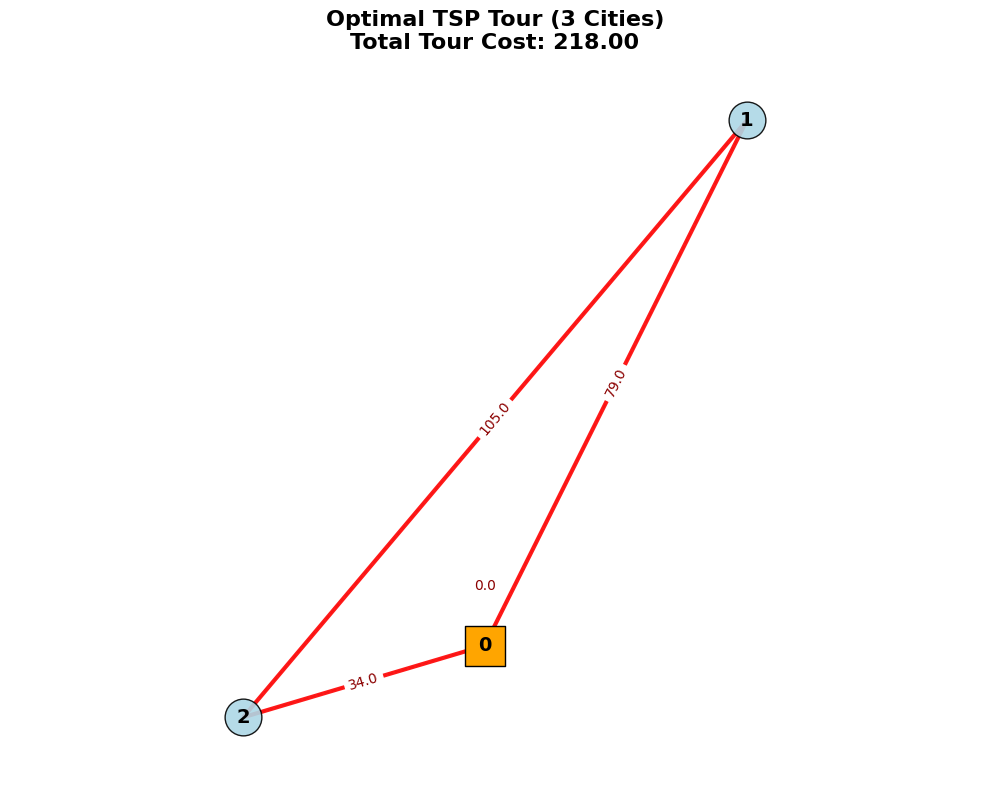


📍 Tour Summary:
   Start City: 0
   Path: 0 → 1 → 2 → 0
   Total Distance: 218.00



In [141]:
G = tsp.graph
pos = {i: G.nodes[i]["pos"] for i in G.nodes()}
visualize_tsp_solution(G, pos, tour, title="Optimal TSP Tour (3 Cities)")

### **From Quadratic Program to QUBO**

Quantum computers solve problems formulated as Hamiltonians. A common step is to first convert the problem into a **Quadratic Unconstrained Binary Optimization (QUBO)** problem. This format represents the problem as a single quadratic equation to be minimized, without any constraints.


In [142]:
problem = tsp.to_quadratic_program()
print(problem.prettyprint())

Problem name: TSP

Minimize
  79*x_0_0*x_1_1 + 79*x_0_0*x_1_2 + 34*x_0_0*x_2_1 + 34*x_0_0*x_2_2
  + 79*x_0_1*x_1_0 + 79*x_0_1*x_1_2 + 34*x_0_1*x_2_0 + 34*x_0_1*x_2_2
  + 79*x_0_2*x_1_0 + 79*x_0_2*x_1_1 + 34*x_0_2*x_2_0 + 34*x_0_2*x_2_1
  + 105*x_1_0*x_2_1 + 105*x_1_0*x_2_2 + 105*x_1_1*x_2_0 + 105*x_1_1*x_2_2
  + 105*x_1_2*x_2_0 + 105*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [143]:
# problem to qubo
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: - 5236 x_0_0 - 5236 x_0_1 - 5236 x_0_2 - 5236 x_1_0 - 5236 x_1_1
      - 5236 x_1_2 - 5236 x_2_0 - 5236 x_2_1 - 5236 x_2_2 + [ 5236 x_0_0^2
      + 5236 x_0_0*x_0_1 + 5236 x_0_0*x_0_2 + 5236 x_0_0*x_1_0 + 158 x_0_0*x_1_1
      + 158 x_0_0*x_1_2 + 5236 x_0_0*x_2_0 + 68 x_0_0*x_2_1 + 68 x_0_0*x_2_2
      + 5236 x_0_1^2 + 5236 x_0_1*x_0_2 + 158 x_0_1*x_1_0 + 5236 x_0_1*x_1_1
      + 158 x_0_1*x_1_2 + 68 x_0_1*x_2_0 + 5236 x_0_1*x_2_1 + 68 x_0_1*x_2_2
      + 5236 x_0_2^2 + 158 x_0_2*x_1_0 + 158 x_0_2*x_1_1 + 5236 x_0_2*x_1_2
      + 68 x_0_2*x_2_0 + 68 x_0_2*x_2_1 + 5236 x_0_2*x_2_2 + 5236 x_1_0^2
      + 5236 x_1_0*x_1_1 + 5236 x_1_0*x_1_2 + 5236 x_1_0*x_2_0 + 210 x_1_0*x_2_1
      + 210 x_1_0*x_2_2 + 5236 x_1_1^2 + 5236 x_1_1*x_1_2 + 210 x_1_1*x_2_0
      + 5236 x_1_1*x_2_1 + 210 x_1_1*x_2_2 + 5236 x_1_2^2 + 210 x_1_2*x_2_0
      + 210 x_1_2*x_2_1 + 5236 x_1_2*x_2_2 + 5236 x_2_0^2 + 5236 x

In [144]:
num_vars = qubo.get_num_vars()
print(f"Number of variables in QUBO: {num_vars}")


Number of variables in QUBO: 9


### **Mapping the QUBO to an Ising Hamiltonian**

The VQE algorithm works by finding the minimum energy (eigenvalue) of a Hamiltonian. We now convert our QUBO problem into an **Ising Hamiltonian**. This Hamiltonian is an operator that can be measured on a quantum computer. Each binary variable in the QUBO is mapped to a qubit.

The conversion gives us two components:

- `qubitOp`: The Ising Hamiltonian, represented as a sum of Pauli operators (Z, ZZ).

- `offset`: A constant energy shift that we'll add back to our final result.

In [145]:
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 8181.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-1365.5 +0.j, -1365.5 +0.j, -1365.5 +0.j, -1401.  +0.j, -1401.  +0.j,
 -1401.  +0.j, -1378.5 +0.j, -1378.5 +0.j, -1378.5 +0.j,   654.5 +0.j,
   654.5 +0.j,   654.5 +0.j,    19.75+0.j,    19.75+0.j,   654.5 +0.j,
     8.5 +0.j,     8.5 +0.j,   654.5 +0.j,    19.75+0.j,   654.5 +0.j,
    19.75+0.j,     8.5 +0.j,   654.5 +0.j,     8.5 +0.j,    

### **The Variational Quantum Eigensolver (VQE)**

VQE is a hybrid quantum-classical algorithm. It uses a quantum computer to prepare a trial wavefunction (using a parameterized circuit called an **ansatz**) and measure the energy of the Hamiltonian. A classical computer then takes this energy and adjusts the parameters of the ansatz to find a new trial state with lower energy. This process is repeated until the minimum energy is found.

#### **The Ansatz**

The ansatz is a parameterized quantum circuit that creates the trial ground state. Its structure is crucial for the success of VQE. A good ansatz should be able to prepare the true ground state of the Hamiltonian. Here, we use `EfficientSU2`, a versatile and commonly used hardware-efficient ansatz from the Qiskit circuit library.


Let's visualize the structure of our ansatz circuit.

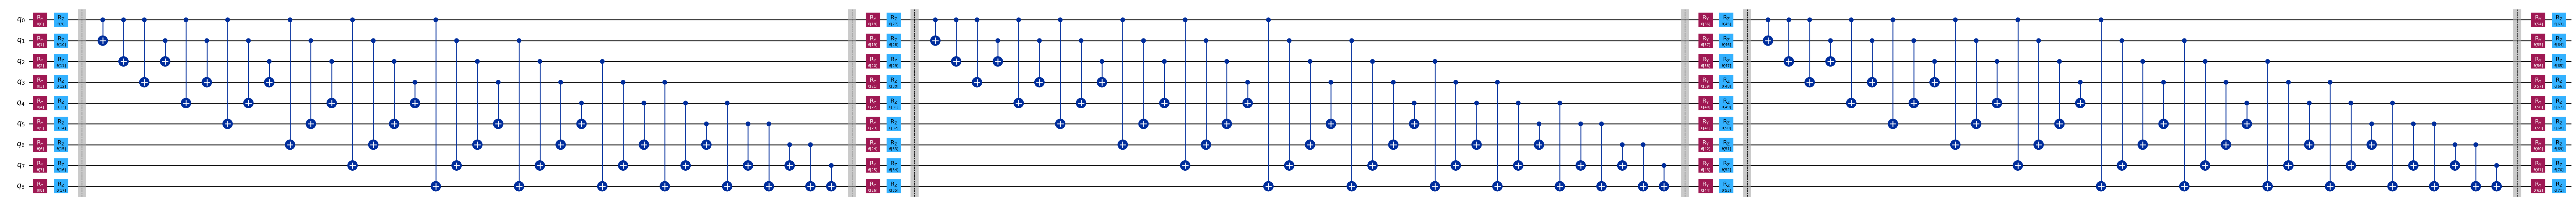

In [146]:
reps = 3 # number of repetitions for the ansatz
ansatz = EfficientSU2(qubitOp.num_qubits, reps=reps, entanglement='full', insert_barriers=True)  # change the entanglement strategy as needed ('full', 'linear', 'circular', etc.)
ansatz.decompose().draw("mpl", style="iqp",fold=-1)

The classical optimizer needs to tune the parameters of this ansatz. The number of parameters determines the complexity of the classical optimization task.

In [147]:
num_params = ansatz.num_parameters
print(f"The ansatz has {num_params} trainable parameters for {ansatz.num_qubits} qubits.")

The ansatz has 72 trainable parameters for 9 qubits.


#### **Executing the VQE Algorithm**

Now we set up and run the VQE algorithm.

- **Cost Function:** We define a `cost_func` that takes the ansatz parameters, builds the circuit, and uses the `Estimator` primitive to calculate the expectation value (energy) of our Hamiltonian. This function returns the energy, which the classical optimizer will try to minimize. We also include a dictionary, `cost_history_dict`, to store the energy at each iteration so we can plot the convergence later.

- **Initial Parameters:** We start the optimization from a random initial set of parameters, `x0`.

- **Classical Optimizer:** We use the `COBYLA` optimizer from `scipy.optimize.minimize` to find the optimal parameters for our ansatz. This optimizer repeatedly calls our `cost_func` to find the parameter values that result in the lowest energy.

In [148]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

This dictionary will store the history of our optimization process.

In [149]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

Let's generate the random starting point for the optimizer

In [150]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([3.20114913, 1.45887776, 3.84625198, 3.15653726, 2.92482144,
       1.72266444, 6.13479042, 3.17663367, 0.34795668, 5.38647024,
       3.33715337, 0.48463624, 3.79244948, 1.44728294, 3.50368109,
       4.08452732, 5.55256367, 0.03615024, 4.80990024, 0.47050746,
       0.90486514, 5.2159298 , 5.80199383, 0.04080188, 3.83354092,
       1.1893667 , 5.44887704, 5.35762519, 1.50492902, 3.80693471,
       4.99094198, 2.18443611, 2.28691693, 2.15178601, 3.54878795,
       0.761152  , 3.08099807, 4.08581712, 0.63977482, 6.02671579,
       5.52832341, 5.80878966, 3.98563661, 2.72134386, 2.36395843,
       5.8181503 , 0.11004531, 5.84405659, 3.07074767, 1.51920074,
       3.41982546, 2.81675807, 5.66839667, 5.61713778, 0.6489077 ,
       6.06286332, 5.72015263, 4.59679541, 2.00294056, 4.52932452,
       4.28947286, 2.90084045, 4.86178537, 3.31307794, 1.33163143,
       1.16102721, 4.16793385, 3.38721809, 2.99046766, 5.41964225,
       5.58636239, 2.14032568])

Now, we run the classical optimizer. It will print the cost at each iteration, giving us a live view of the VQE's progress as it searches for the minimum energy.

In [151]:
ansatz = ansatz.decompose()

res = minimize(
        cost_func,
        x0,
        args=(ansatz, qubitOp, estimator),
        method="cobyla", # You can change the method to 'nelder-mead', 'bfgs', etc. as needed
        options={"maxiter": 1000, "disp": True}, # also can adjust the options like 'maxiter', 'disp', 'rhobeg', 'tol' as needed
        tol=1e-6,  # tolerance for convergence    
    )


Iters. done: 1 [Current cost: 500.7998046875]
Iters. done: 2 [Current cost: 422.35302734375]
Iters. done: 3 [Current cost: 410.290283203125]
Iters. done: 4 [Current cost: -37.0517578125]
Iters. done: 5 [Current cost: 269.4560546875]
Iters. done: 6 [Current cost: -162.911376953125]
Iters. done: 7 [Current cost: -271.133544921875]
Iters. done: 8 [Current cost: 90.645751953125]
Iters. done: 9 [Current cost: -391.870361328125]
Iters. done: 10 [Current cost: -873.322265625]
Iters. done: 11 [Current cost: -1325.73388671875]
Iters. done: 12 [Current cost: -1245.764892578125]
Iters. done: 13 [Current cost: -1117.189208984375]
Iters. done: 14 [Current cost: -1403.878662109375]
Iters. done: 15 [Current cost: -1268.90673828125]
Iters. done: 16 [Current cost: -1200.98876953125]
Iters. done: 17 [Current cost: -1317.966552734375]
Iters. done: 18 [Current cost: -1027.013427734375]
Iters. done: 19 [Current cost: -1340.4306640625]
Iters. done: 20 [Current cost: -1219.436279296875]
Iters. done: 21 [Curr

The optimizer has successfully terminated. The `res` object contains the results, including the final minimized energy (`fun`) and the optimal parameters (`x`).

In [152]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -7246.908935546875
       x: [ 3.121e+00  2.947e+00 ...  5.905e+00  1.988e+00]
    nfev: 1000
   maxcv: 0.0

### **Post-Processing: Analyzing the Results**

Let's analyze the outcome of our VQE run. First, we can confirm that the final parameters from the optimizer match what we stored in our history dictionary.

In [153]:
all(cost_history_dict["prev_vector"] == res.x)


False

Now, let's plot the cost (energy) against the number of iterations. This convergence plot shows how the VQE algorithm progressively found lower energy states until it converged on a solution.

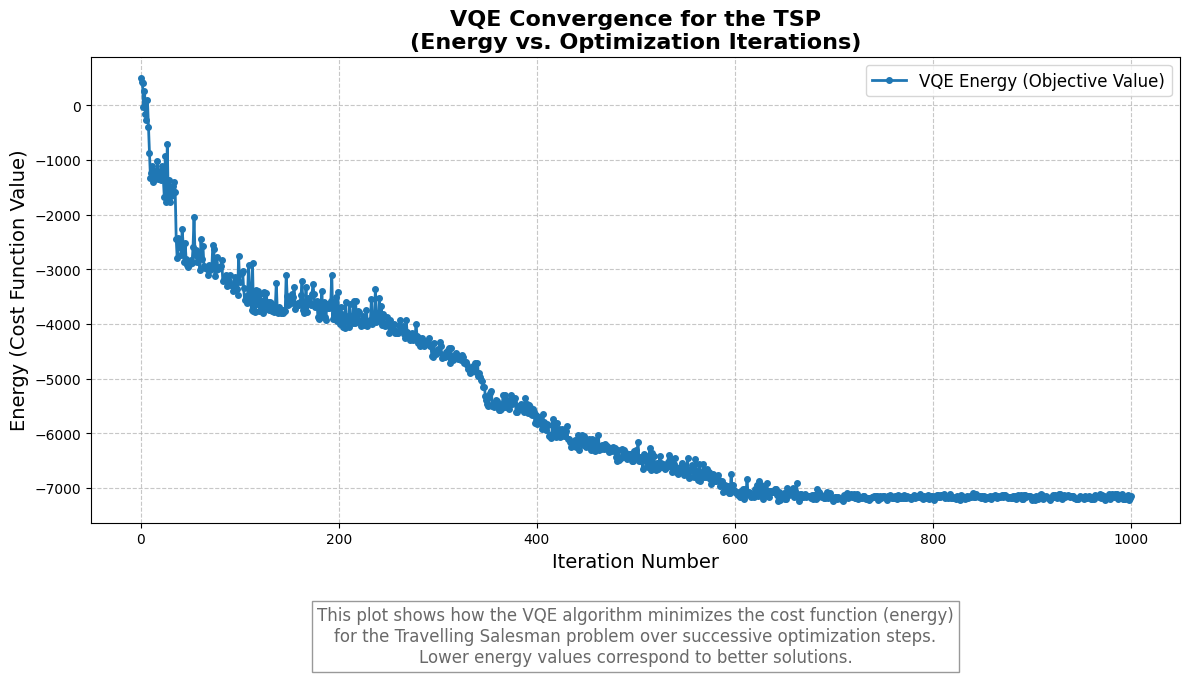

In [154]:
fig, ax = plt.subplots(figsize=(12, 7))  # Bigger figure

ax.plot(
    range(cost_history_dict["iters"]),
    cost_history_dict["cost_history"],
    color="tab:blue",
    linewidth=2,
    marker="o",
    markersize=4,
    label="VQE Energy (Objective Value)"
)

# Add annotations and explanations
ax.set_xlabel("Iteration Number", fontsize=14)
ax.set_ylabel("Energy (Cost Function Value)", fontsize=14)
ax.set_title("VQE Convergence for the TSP\n(Energy vs. Optimization Iterations)", fontsize=16, fontweight="bold")
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend(fontsize=12)

# Add a text box explaining the plot
explanation = (
    "This plot shows how the VQE algorithm minimizes the cost function (energy)\n"
    "for the Travelling Salesman problem over successive optimization steps.\n"
    "Lower energy values correspond to better solutions."
)
ax.text(
    0.5, -0.18, explanation,
    fontsize=12, color="dimgray", ha="center", va="top", transform=ax.transAxes,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
)

plt.tight_layout()
plt.show()

### Run the Optimized Circuit and Sample the Solution

The VQE optimization has given us the best parameters for our ansatz. We now plug these parameters into the circuit to prepare the approximate ground state of our Hamiltonian.

Since the goal is to find the solution bitstring, we add measurements to all qubits and use the `Sampler` primitive to run the circuit many times (e.g., 10,000 "shots") and collect the measurement outcomes.

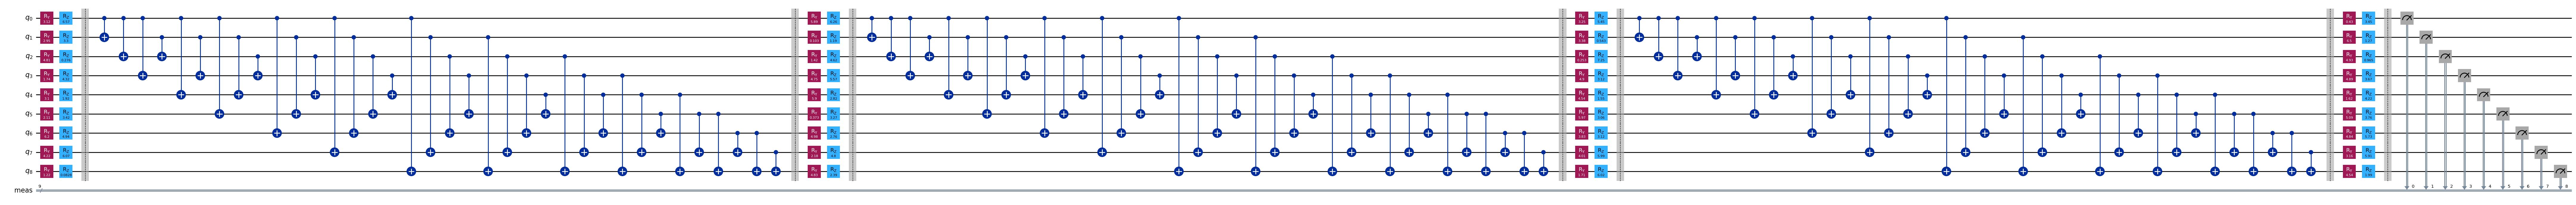

In [155]:
ansatz = ansatz.assign_parameters(res.x)
ansatz.measure_all()
ansatz.draw("mpl", style="iqp",fold=-1)

In [156]:
pub = (ansatz,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

The output of the sampler is a probability distribution over all possible measurement outcomes (bitstrings). The bitstring with the highest probability is our candidate for the optimal solution.

In [157]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_vars)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 0, 1, 1, 0, 0, 0, 1, 0]


In [158]:
result = converter.interpret(most_likely_bitstring)
cost = problem.objective.evaluate(result)
feasible =problem.get_feasibility_info(result)[0]


print("Result TSP:", result)
print("Result value:", cost)
print("Feasible:", feasible)

Result TSP: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Result value: 218.0
Feasible: True


In [159]:
print("="*40)
print("🔎 Best Known Classical Solution")
print("="*40)
print(f"  • Total Value:        {m.objective_value}")

print()

print("="*40)
print("⚛️  VQE (Quantum) Solution")
print("="*40)
print(f"  • Total Value:        {cost}")
print(f"  • Solution Vector:    {result}")
print(f"  • Feasible:           {feasible}")

if feasible:
    optimality_gap = 100 * (m.objective_value - cost) / m.objective_value
    print(f"  • Optimality Gap:     {optimality_gap:.2f}%")
else:
    print("  • Note: Quantum solution is not feasible.")

print("\n" + "-"*40)
if feasible:
    if abs(cost - m.objective_value) < 1e-6:
        print("✅ Quantum solution matches the classical optimum!")
    else:
        print("ℹ️  Quantum solution is suboptimal compared to classical.")
else:
    print("❌ Quantum solution is not feasible.")
print("-"*40)

🔎 Best Known Classical Solution
  • Total Value:        218.0

⚛️  VQE (Quantum) Solution
  • Total Value:        218.0
  • Solution Vector:    [0. 0. 1. 1. 0. 0. 0. 1. 0.]
  • Feasible:           True
  • Optimality Gap:     0.00%

----------------------------------------
✅ Quantum solution matches the classical optimum!
----------------------------------------


Because VQE is a heuristic and quantum measurements are probabilistic, the highest probability state might not always be the correct one. It's often useful to examine the top few most likely outcomes.

In [160]:
# Find the indices of the top 4 values
top_4_indices = np.argsort(np.abs(values))[::-1][:4]
top_4_results = []

# Define column widths
col_widths = {
    "Rank": 5,
    "Probability": 12,
    "TSP Solution": 23,
    "Value": 9,
    "Feasible": 10,
    "Optimality Gap (%)": 20
}

# Table header with aligned columns
header = (
    f"{'Rank':<{col_widths['Rank']}} | "
    f"{'Probability':<{col_widths['Probability']}} | "
    f"{'TSP Solution':<{col_widths['TSP Solution']}} | "
    f"{'Value':<{col_widths['Value']}} | "
    f"{'Feasible':<{col_widths['Feasible']}} | "
    f"{'Optimality Gap (%)':<{col_widths['Optimality Gap (%)']}}"
)
print("\nTop 4 Most Probable Solutions from VQE Measurement:\n")
print(header)
print("=" * len(header))

for rank, idx in enumerate(top_4_indices, 1):
    bitstring = to_bitstring(keys[idx], num_vars)
    bitstring.reverse()
    top_4_results.append(bitstring)
    interpreted = converter.interpret(bitstring)
    value = problem.objective.evaluate(interpreted)
    feasible = problem.get_feasibility_info(interpreted)[0]
    if feasible and m.objective_value != 0:
        optimality_gap = 100 * (m.objective_value - value) / m.objective_value
        gap_str = f"{optimality_gap:>18.2f}"
    else:
        gap_str = f"{'N/A':>{col_widths['Optimality Gap (%)']}}"
    print(
        f"{rank:<{col_widths['Rank']}} | "
        f"{values[idx]:<{col_widths['Probability']}.6f} | "
        f"{str(interpreted):<{col_widths['TSP Solution']}} | "
        f"{value:<{col_widths['Value']}} | "
        f"{str(feasible):<{col_widths['Feasible']}} | "
        f"{gap_str}"
    )
print("=" * len(header))



Top 4 Most Probable Solutions from VQE Measurement:

Rank  | Probability  | TSP Solution            | Value     | Feasible   | Optimality Gap (%)  
1     | 0.390900     | [0. 0. 1. 1. 0. 0. 0. 1. 0.] | 218.0     | True       |               0.00
2     | 0.376000     | [0. 0. 1. 0. 1. 0. 1. 0. 0.] | 218.0     | True       |               0.00
3     | 0.027000     | [0. 0. 0. 0. 1. 1. 1. 0. 0.] | 210.0     | False      |                  N/A
4     | 0.019400     | [0. 0. 0. 1. 0. 1. 0. 1. 0.] | 210.0     | False      |                  N/A
